Install Dependencies and Import Required Packages

In [1]:
# !sudo add-apt-repository ppa:openjdk-r/ppa
!sudo apt-get install openjdk-11-jdk
# To Install Oracke JDK varsion 8
# !sudo add-apt-repository ppa:webupd8team/java
# !sudo apt-get install oracle-java8-installer

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libfontenc1 libxkbfile1 libxtst6 libxxf86dga1
  openjdk-11-jre x11-utils
Suggested packages:
  openjdk-11-demo openjdk-11-source visualvm mesa-utils
The following NEW packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libfontenc1 libxkbfile1 libxtst6 libxxf86dga1
  openjdk-11-jdk openjdk-11-jre x11-utils
0 upgraded, 11 newly installed, 0 to remove and 24 not upgraded.
Need to get 5,128 kB of archives.
After this operation, 13.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/main amd64 fonts-dejavu-core all 2.37-1 [1,041 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/main amd64 fonts-dejavu-extra all 2.37-1 [1,953 kB]
Get:3 http://archive.ubuntu.com/ubunt

In [2]:
# !wget -q https://downloads.apache.org/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
# !tar xvzf spark-3.1.1-bin-hadoop3.2.tgz
!pip install pyspark
!pip install -q findspark
!pip install pyarrow
try:
  # %tensorflow_version only exists in Colab.
  !pip install  tf-estimator-nightly==2.8.0.dev2021122109
except Exception:
  pass

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 23.8 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824028 sha256=c5650a8868e5edf70142ade7520858f140e1c53e262f40b50debb3f3ac9fa37b
  Stored in directory: /root/.cache/pip/wheels/6c/e3/9b/0525ce8a69478916513509d43693511463c6468db0de237c86
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.1"


In [20]:
from pyspark.sql.functions import *
import io

from tensorflow.keras.applications.imagenet_utils import decode_predictions
import pandas as pd
from pyspark.sql.functions import col, pandas_udf, PandasUDFType

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image

from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import pathlib
import findspark
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt 


findspark.init()
spark = SparkSession.builder.master("local[*]").getOrCreate()

Uploading CIFAR 10 set to the session and Preprocessing:

In [5]:
!wget https://www.cs.toronto.edu/%7Ekriz/cifar-10-python.tar.gz

--2023-04-06 04:23:11--  https://www.cs.toronto.edu/%7Ekriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  14.3MB/s    in 13s     

2023-04-06 04:23:26 (12.4 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



In [6]:
!tar xvf cifar-10-python.tar.gz

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [7]:
import pickle
import numpy as np
from PIL import Image as im
import os
import shutil

def feature_extractor(batch_id):
  
  batch_file = open('./cifar-10-batches-py/data_batch_' + str(batch_id), mode='rb') 
    
  batch = pickle.load(batch_file, encoding='latin1')
      
  features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
  labels = batch['labels']

  return features, labels

def write_imagenet_format(features_stack, labels_stack, data_path):
  classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

  if not os.path.exists(data_path):
    os.makedirs(data_path)

  for item in classes:
    sub_folder = os.path.join(data_path,item)
    if not os.path.exists(sub_folder):
      os.mkdir(sub_folder)

  for i in range(features_stack.shape[0]):
    samp = features_stack[i]
    item = np.squeeze(labels_stack[i])
    data = im.fromarray(samp, 'RGB')
    data_save_path = os.path.join(data_path,classes[item],str(i)+'.jpg')
    data.save(data_save_path)

features_temp = np.array([])
labels_temp = np.array([])

for batch_id in range(1,6):
  features, labels = feature_extractor( batch_id)
  labels = np.expand_dims(np.squeeze(labels),1)
  if batch_id != 1:
    features_stack = np.vstack([features_temp, features])
    labels_stack = np.vstack([labels_temp, labels])
    features_temp = features_stack
    labels_temp = labels_stack
  else:
    features_temp = features
    labels_temp = labels
  


train_path = 'cifar_10_data/train_data'
write_imagenet_format(features_stack, labels_stack, train_path)


test_file =  open('./cifar-10-batches-py/test_batch', mode='rb')
batch = pickle.load(test_file, encoding='latin1')
test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
test_labels = batch['labels']

test_path = 'cifar_10_data/test_data'
write_imagenet_format(test_features, test_labels, test_path)


Recursively Read all the Images from the Parent directory and create a DataFrame

In [8]:
images = spark.read.format("binaryFile").option("recursiveFileLookup", "true").option("pathGlobFilter", "*.jpg").load('./cifar_10_data/train_data')
print(type(images))

<class 'pyspark.sql.dataframe.DataFrame'>


In [9]:
images.show(5)

+--------------------+--------------------+------+--------------------+
|                path|    modificationTime|length|             content|
+--------------------+--------------------+------+--------------------+
|file:/content/cif...|2023-04-06 04:23:...|  1124|[FF D8 FF E0 00 1...|
|file:/content/cif...|2023-04-06 04:23:...|  1121|[FF D8 FF E0 00 1...|
|file:/content/cif...|2023-04-06 04:23:...|  1118|[FF D8 FF E0 00 1...|
|file:/content/cif...|2023-04-06 04:23:...|  1111|[FF D8 FF E0 00 1...|
|file:/content/cif...|2023-04-06 04:23:...|  1104|[FF D8 FF E0 00 1...|
+--------------------+--------------------+------+--------------------+
only showing top 5 rows



In [10]:
files=images.select('path').rdd.map(lambda x :x.path ).collect()
files[0:10]

['file:/content/cifar_10_data/train_data/frog/14231.jpg',
 'file:/content/cifar_10_data/train_data/bird/29920.jpg',
 'file:/content/cifar_10_data/train_data/truck/1827.jpg',
 'file:/content/cifar_10_data/train_data/automobile/44107.jpg',
 'file:/content/cifar_10_data/train_data/truck/40040.jpg',
 'file:/content/cifar_10_data/train_data/truck/6275.jpg',
 'file:/content/cifar_10_data/train_data/truck/33639.jpg',
 'file:/content/cifar_10_data/train_data/frog/2898.jpg',
 'file:/content/cifar_10_data/train_data/airplane/43875.jpg',
 'file:/content/cifar_10_data/train_data/automobile/1421.jpg']

In [11]:
def extract_label(path_col):
  """Extract label from file path using built-in SQL functions."""
  return regexp_extract(path_col, "./cifar_10_data/train_data/([^/]+)", 1)

def extract_size(content):
  """Extract image size from its raw content."""
  image = Image.open(io.BytesIO(content))
  return image.size

@pandas_udf("width: int, height: int")
def extract_size_udf(content_series):
  sizes = content_series.apply(extract_size)
  return pd.DataFrame(list(sizes))

df = images.select(
  col("path"),
  col("modificationTime"),
  extract_label(col("path")).alias("label"),
  extract_size_udf(col("content")).alias("size"),
  col("content"))


df.show(5)


+--------------------+--------------------+----------+--------+--------------------+
|                path|    modificationTime|     label|    size|             content|
+--------------------+--------------------+----------+--------+--------------------+
|file:/content/cif...|2023-04-06 04:23:...|      frog|{32, 32}|[FF D8 FF E0 00 1...|
|file:/content/cif...|2023-04-06 04:23:...|      bird|{32, 32}|[FF D8 FF E0 00 1...|
|file:/content/cif...|2023-04-06 04:23:...|     truck|{32, 32}|[FF D8 FF E0 00 1...|
|file:/content/cif...|2023-04-06 04:23:...|automobile|{32, 32}|[FF D8 FF E0 00 1...|
|file:/content/cif...|2023-04-06 04:23:...|     truck|{32, 32}|[FF D8 FF E0 00 1...|
+--------------------+--------------------+----------+--------+--------------------+
only showing top 5 rows



In [12]:
ima=images.select('content').rdd.map(lambda x: x.content).collect()

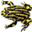

In [13]:
imgg = Image.open(io.BytesIO(ima[0]))
imgg

In [14]:
class ImageNetDataset(Dataset):
  """
  Converts image contents into a PyTorch Dataset with standard ImageNet preprocessing.
  """
  def __init__(self, contents):
    self.contents = contents

  def __len__(self):
    
    return len(self.contents)

  def __getitem__(self, index):
    return self._preprocess(self.contents[index])

  def _preprocess(self, content):
    """
    Preprocesses the input image content using standard ImageNet normalization.
    
    See https://pytorch.org/docs/stable/torchvision/models.html.
    """
    image = Image.open(io.BytesIO(content))
    transform = transforms.Compose([
      transforms.Resize(256),                         ### Smaller lenght is convertd to 256 
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return transform(image)

In [15]:

def imagenet_model_udf(model_fn):
  """
  Wraps an ImageNet model into a Pandas UDF that makes predictions.
  
  You might consider the following customizations for your own use case:
    - Tune DataLoader's batch_size and num_workers for better performance.
    - Use GPU for acceleration.
    - Change prediction types.
  """
  def predict(content_series_iter : pd.Series) -> pd.DataFrame:
    model = model_fn() 
    model.eval()      
    for content_series in content_series_iter:                                                    #Iterates overall all Images 
      dataset = ImageNetDataset(list(content_series))                                           
      loader = DataLoader(dataset, batch_size=64) 
      with torch.no_grad():
        for image_batch in loader:
          predictions = model(image_batch).numpy()                                                # Predictions for all 1000 classes of Mobilenetv2 Training Dataset
          predicted_labels = [x[0] for x in decode_predictions(predictions, top=1)]                       
          yield pd.DataFrame(predicted_labels)
    
        
  return_type = "class: string, desc: string, score:float"
  # return_type = "class: string"                                         # SCALAR_ITER implies the function accepts list/array of scalar values as input.
  return pandas_udf(predict,return_type, PandasUDFType.SCALAR_ITER)   
  # return pandas_udf(return_type, PandasUDFType.SCALAR_ITER)(predict)   
  
  #Returns a Predict function object as the final user defined function object.
  #Iterates over an Image: A sequence of bytes represented as a 2D array. 
  #Scalar is a series of bytes.    

In [16]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Using Imagenet Model to make predictions

In [18]:
predictions_class_imagenet =[]
predictions_count_imagenet = []

imagenet_udf = imagenet_model_udf(lambda: models.mobilenet_v2(pretrained=True))
predictions = df.withColumn("prediction", imagenet_udf(col("content")))
prediction_imagenet = predictions.select(col("label").alias('Class'),col("prediction.desc").alias("Imagenet prediction"))
pred_df = prediction_imagenet.limit(1000).toPandas() #Limiting to convert only the first 1000 rows into pandas dataframe to increase speed of the model
for item in classes:
  rows_df = pred_df.loc[pred_df['Class'] == item]
  predicted_class_count = rows_df['Imagenet prediction'].value_counts().nlargest(1).tolist()[0]
  predicted_class = rows_df['Imagenet prediction'].value_counts().nlargest(1).keys().tolist()[0] # Assign the label with highest count frequency as the predicted label
  predictions_class_imagenet.append(predicted_class)
  predictions_count_imagenet.append(predicted_class_count)

/usr/local/lib/python3.9/dist-packages/pyspark/sql/pandas/functions.py:394: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [19]:
tuple_list_imagenet = list(zip(classes,predictions_class_imagenet))
imagenet_df = spark.createDataFrame(tuple_list_imagenet, ['Actual Class Label', 'Imagenet Prediction Label'])
imagenet_df.show() #Displaying the final prediction of the pretrained model

+------------------+-------------------------+
|Actual Class Label|Imagenet Prediction Label|
+------------------+-------------------------+
|          airplane|                chain_saw|
|        automobile|               moving_van|
|              bird|             fox_squirrel|
|               cat|              EntleBucher|
|              deer|                  cardoon|
|               dog|         Japanese_spaniel|
|              frog|              rock_python|
|             horse|                   sorrel|
|              ship|               moving_van|
|             truck|               moving_van|
+------------------+-------------------------+



In [50]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Experimentation with different Models:


In [22]:
model_class = []

In [34]:
predictions_class =[]
predictions_count = []

In [35]:
densenet121_udf = imagenet_model_udf(lambda: models.densenet121(pretrained=True))
predictions = df.withColumn("prediction", densenet121_udf(col("content")))
predictions_densenet121 = predictions.select(col("label"),col("prediction.desc").alias("densenet121 prediction"))
pred_dense_df = predictions_densenet121.limit(1000).toPandas()
top_num = 3
for item in classes:
  rows_df = pred_dense_df.loc[pred_dense_df['label'] == item]
  predicted_class_count = rows_df['densenet121 prediction'].value_counts().nlargest(1).tolist()[0]
  predicted_class = rows_df['densenet121 prediction'].value_counts().nlargest(1).keys().tolist()[0]
  predictions_class.append(predicted_class)
  predictions_count.append(predicted_class_count)


/usr/local/lib/python3.9/dist-packages/pyspark/sql/pandas/functions.py:394: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [38]:
predictions_class_alexnet =[]

In [39]:
alexnet_udf = imagenet_model_udf(lambda: models.alexnet(pretrained=True))
predictions = df.withColumn("prediction", alexnet_udf(col("content")))
predictions_alexnet = predictions.select(col("label"),col("prediction.desc").alias("alexnet prediction"))
pred_alex_df = predictions_alexnet.limit(1000).toPandas()
top_num = 3
for item in classes:
  filt_rows = pred_alex_df.loc[pred_alex_df['label'] == item]
  predicted_class_count = filt_rows['alexnet prediction'].value_counts().nlargest(1).tolist()[0]
  predicted_class = filt_rows['alexnet prediction'].value_counts().nlargest(1).keys().tolist()[0]
  predictions_class_alexnet.append(predicted_class)

/usr/local/lib/python3.9/dist-packages/pyspark/sql/pandas/functions.py:394: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [41]:
predictions_class_shufflenet =[]

In [42]:
shufflenet_udf = imagenet_model_udf(lambda: models.shufflenet_v2_x1_0(pretrained=True))
predictions = df.withColumn("prediction", shufflenet_udf(col("content")))
predictions_shufflenet = predictions.select(col("label"),col("prediction.desc").alias("shufflenet prediction"))
ser_df = predictions_shufflenet.limit(1000).toPandas()
top_num = 3
for item in classes:
  filt_rows = ser_df.loc[ser_df['label'] == item]
  predicted_class_count = filt_rows['shufflenet prediction'].value_counts().nlargest(1).tolist()[0]
  predicted_class = filt_rows['shufflenet prediction'].value_counts().nlargest(1).keys().tolist()[0]
  predictions_class_shufflenet.append(predicted_class)

/usr/local/lib/python3.9/dist-packages/pyspark/sql/pandas/functions.py:394: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [43]:
predictions_class_resnet50 =[]

In [45]:
resnet50_udf = imagenet_model_udf(lambda: models.resnet50(pretrained=True))
predictions = df.withColumn("prediction", resnet50_udf(col("content")))
predictions_resnet50 = predictions.select(col("label"),col("prediction.desc").alias("resnet50 prediction"))
ser_df = predictions_resnet50.limit(1000).toPandas()
top_num = 3
for item in classes:
  filt_rows = ser_df.loc[ser_df['label'] == item]
  predicted_class_count = filt_rows['resnet50 prediction'].value_counts().nlargest(1).tolist()[0]
  predicted_class = filt_rows['resnet50 prediction'].value_counts().nlargest(1).keys().tolist()[0]
  predictions_class_resnet50.append(predicted_class)

/usr/local/lib/python3.9/dist-packages/pyspark/sql/pandas/functions.py:394: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [46]:
tuple_list = list(zip(classes,predictions_class, predictions_class_alexnet, predictions_class_shufflenet,predictions_class_resnet50))

In [48]:
models_df = spark.createDataFrame(tuple_list, ['Actual Class', 'Densenet Prediction', 'Alexnet Prediction','Shufflenet Prediction','Resnet50 Prediction'])

In [49]:
models_df.show()

+------------+-------------------+--------------------+---------------------+-------------------+
|Actual Class|Densenet Prediction|  Alexnet Prediction|Shufflenet Prediction|Resnet50 Prediction|
+------------+-------------------+--------------------+---------------------+-------------------+
|    airplane|           airliner|             panpipe|          Windsor_tie|      letter_opener|
|  automobile|         moving_van|          moving_van|           moving_van|         moving_van|
|        bird|            limpkin|        fox_squirrel|               langur|            limpkin|
|         cat|       fox_squirrel|    English_foxhound|               langur|       fox_squirrel|
|        deer|             sorrel|      Dandie_Dinmont|              limpkin|        toy_terrier|
|         dog|     Dandie_Dinmont|wire-haired_fox_t...|     Japanese_spaniel|   Japanese_spaniel|
|        frog|       fox_squirrel|        fox_squirrel|         fox_squirrel|        tailed_frog|
|       horse|      